In [1]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler, QuadraticDiscriminantAnalysis
import plotly.graph_objs as go
import plotly.io as pio
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier

f = '/Users/shenchingfeng/Documents/1112/機器學習/Homework 2/all.csv'

df = pd.read_csv(f)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) ## Red wine == 1 ; White wine == 0

result = pd.DataFrame(columns = ["model", "accuracy"])

select_col = df.drop('wine', axis = 1).columns
for i in select_col:
    df[i], lambda_value = stats.yeojohnson(df[i])

# Cross Validation

### 10-Fold CV

In [3]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

### Grid Search CV

In [4]:
model = KNeighborsClassifier()

X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

params = {
    'n_neighbors': list(range(1, 11)),
    'leaf_size': list(range(10, 41, 5)),
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(model, param_grid = params, cv = kf, n_jobs = -1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

result = result.append({
    'model': 'K Nearest Neighbor', 
    'accuracy': round(grid_search.best_score_, 4)
    }, 
    ignore_index = True
)

Best parameters: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best score: 0.9516712101457865


/var/folders/56/1hl93h654354jd5vh2zjmd640000gn/T/ipykernel_29761/2349206726.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({


# Feature Selection

## Stepwise Selection

In [5]:
for i in range(X.shape[1]):
    sfs = SFS(
    cv = kf, 
    estimator = KNeighborsClassifier(leaf_size =  10, metric = 'manhattan', n_neighbors = 9, p = 1, weights = 'distance'),
    forward = True,
    floating = True,
    k_features = i+1, 
    scoring='f1',
    n_jobs = -1
)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)
    print(sfs.k_score_)
    print("=======================================")

('total sulfur dioxide',)
0.7482087946686651
('chlorides', 'total sulfur dioxide')
0.940538601193578
('chlorides', 'total sulfur dioxide', 'alcohol')
0.9452761454949721
('chlorides', 'total sulfur dioxide', 'pH', 'alcohol')
0.9430319718618195
('fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'alcohol')
0.9475309313931468
('fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol')
0.9408405477844564
('fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'pH', 'sulphates', 'alcohol')
0.9464276103208107
('fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates', 'alcohol')
0.9305671716995503
('fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates', 'alcohol', 'quality')
0.919973204379624
('fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol', 'quality')
0.903658639048502
('fixed a

In [6]:
import plotly.graph_objects as go

metric_dict = sfs.get_metric_dict()
k_features = list(metric_dict.keys())
avg_scores = np.array([metric_dict[k]['avg_score'] for k in k_features])
std_devs = np.array([metric_dict[k]['std_dev'] for k in k_features])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x = k_features, y = avg_scores, 
    mode = 'lines+markers', name = 'Average Score'
    )
)

fig.update_layout(
    title = {
        'text': 'Stepwise Selection',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    }, 
    xaxis_title = {
        'text': 'Number of Features',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Performence (F1)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    width = 1200, height = 800
)

fig.show()

## Lasso

In [7]:
X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

from sklearn.linear_model import Lasso
lasso = Lasso()
params = {
    'alpha': [10**i for i in range(-10, 11)],
    'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid = params, cv = kf, n_jobs = -1)
gridlasso.fit(X, y)

print("Best alpha:", gridlasso.best_params_)
print("Best scores:", gridlasso.best_score_)

coefficients = gridlasso.best_estimator_.coef_
importance = np.abs(coefficients)
print(np.array(X.columns)[importance > 1])
print(importance)

Best alpha: {'alpha': 1e-08, 'selection': 'random'}
Best scores: 0.831286026389092
['fixed acidity' 'volatile acidity' 'chlorides' 'pH' 'sulphates' 'alcohol']
[1.94012268e+01 3.13999017e+00 1.15308808e-01 1.18270866e-02
 2.08427751e+01 1.89202680e-02 7.04227275e-03 4.42252089e+01
 2.38130996e+00 1.87684774e+01 2.36408251e-02]


In [ ]:
best_lasso = gridlasso.best_estimator_

alphas = np.array(gridlasso.cv_results_['param_alpha'].data, dtype = 'float')
coefs = gridlasso.cv_results_['mean_test_score']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = np.log10(alphas), y = coefs, 
    mode = 'lines+markers'
    )
)

fig.update_layout(
    title = {
        'text': 'Lasso coefficients as a function of Log alpha',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 
        'x': 0.5
    }, 
    width = 1200, height = 800,
    xaxis_title = {
        'text': 'Log(alpha)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Coefficient',
        'font': {'size': 24, 'family': 'Gulliver'}
    }, 
)

fig.show()

## Feature Group

In [8]:
Stepwise = ['chlorides', 'total sulfur dioxide', 'alcohol']
Lasso =  ['fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']

feature = []

for i in df.drop('wine', axis = 1).columns:
    for i in Stepwise:
        if i not in feature:
            feature.append(i)
        else:
            continue
    for i in Lasso:
        if i not in feature:
            feature.append(i)
        else:
            continue
print(feature)

['chlorides', 'total sulfur dioxide', 'alcohol', 'fixed acidity', 'volatile acidity', 'pH', 'sulphates']


# Model

In [27]:
X = df[feature]
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

knn = KNeighborsClassifier(leaf_size =  10, metric = 'manhattan', n_neighbors = 9, p = 1, weights = 'distance')
model = knn.fit(x_train, y_train)
y_pred = model.predict(x_test)

## Model Performance

[7/7] features ████████████████████ Time elapsed: 0 seconds

Text(0.5, 1.0, 'Feature Importance of KNN')

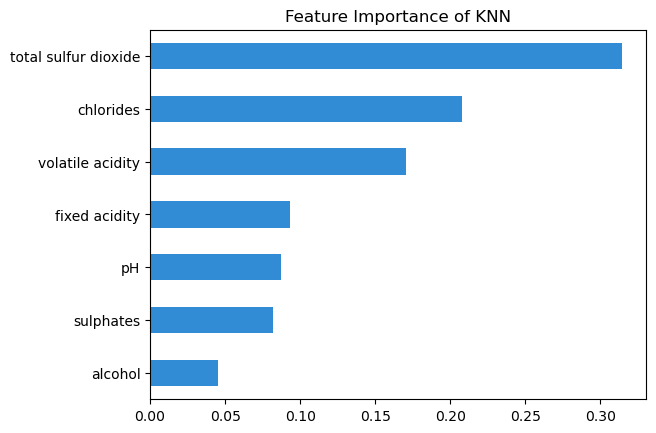

In [21]:
interpreter = Interpretation(
    x_test, feature_names = X.columns
)

pyint_model = InMemoryModel(
    knn.predict_proba,
    examples = x_train
)

plots= interpreter.feature_importance.plot_feature_importance(pyint_model, ascending = False, progressbar = True)
plt.title('Feature Importance of KNN')

## Decision Region

In [23]:
feature_name = 'total sulfur dioxide'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)
feature_name = 'chlorides'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)

1
0


### With mlxtend.plotting plot_decision_regions()

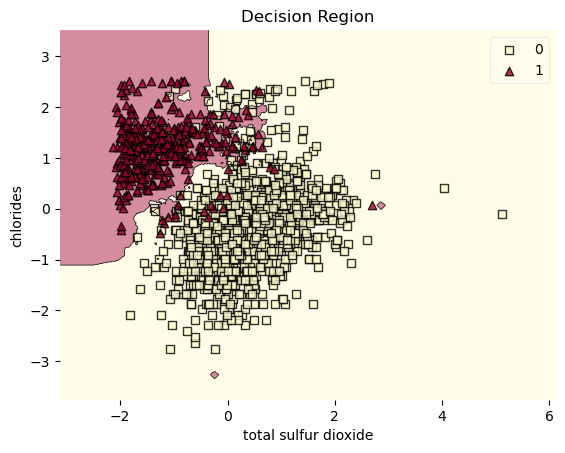

In [24]:
plot_decision_regions(
    x_test[:, [1, 0]], 
    y_test.values, 
    clf =knn.fit(x_train[:, [1, 0]], y_train.values),
    colors = '#fffacd,#a00028'
)

plt.title('Decision Region')
plt.xlabel('total sulfur dioxide')
plt.ylabel('chlorides')
plt.show()

### With Scatter plot of Plotly

In [ ]:
trace = go.Scatter(
    x = x_test[:, 1],
    y = x_test[:, 6],
    mode = 'markers',
    marker = dict(
        color = y_pred,
        symbol = y_pred,
        size = 8,
        opacity = 0.9,
        colorscale = [[0, '#fffacd'], [1, '#a00028']],
        line = dict(color = '#444444', width = 0.5)
    )
)

layout = go.Layout(
    title = {
        'text': 'Decision Region',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    },
    xaxis = dict(
        title = {
            'text': 'volatile acidity', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    yaxis = dict(
        title = {
            'text': 'total sulfur dioxide', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    margin = dict(l = 50, r = 50, t = 80, b = 50),
    hovermode = 'closest', 
    width = 800, height = 800,
    showlegend = False,
    template = 'ggplot2'
)

fig = go.Figure(
    data = [trace], 
    layout = layout
)

pio.show(fig)

## Confusion Matrix

In [25]:
acu = metrics.accuracy_score(y_test, y_pred)
pre_class, r_class, f_class, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average = 'weighted')

print("Acurracy: ", round(acu * 100, 4), '%')
print('Precision:', round(pre_class * 100, 4), '%')
print('Recall:', round(r_class * 100, 4), '%')
print('f1:', round(f_class * 100, 4), '%')

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_norm = pd.DataFrame(cm_norm)
cm_norm

Acurracy:  99.4462 %
Precision: 99.4458 %
Recall: 99.4462 %
f1: 99.446 %


,0,1
0,0.996641,0.003359
1,0.011521,0.988479


## Receiver Operating Characteristic Curve

In [28]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
    y_test, 
    model.predict_proba(x_test)[:, 1]
)

roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(
    x = fpr, y = tpr, 
    mode = 'lines', 
    line = dict(width = 2),
)

trace2 = go.Scatter(
        x = [0, 1], y = [0, 1],
        mode = 'lines',
        line = dict(color = 'navy', width = 2, dash = 'dash'),
        showlegend = False
)

layout = go.Layout(
        title = {
            'text': 'ROC Curves (AUC = {:0.2f})'.format(roc_auc),
            'font': {
                'size': 40, 'family': 'Gulliver'
            }, 
            'x': 0.5, 'y': 0.95
        },
        xaxis = dict(
            title = {
                'text': 'False Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        yaxis = dict(
            title = {
                'text': 'True Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        width = 1200, height = 800,
        showlegend = False
)

fig = go.Figure(
    data = [trace1, trace2], 
    layout = layout
)

fig.show()

# Model Compexity

In [31]:
k_range = range(1, 31)

train_errors = []
test_errors = []

for k in k_range:
    knn = KNeighborsClassifier(leaf_size =  10, metric = 'manhattan', n_neighbors = k, p = 1, weights = 'distance', n_jobs = -1)
    knn.fit(x_train, y_train)
    train_errors.append(1 - knn.score(x_train, y_train))
    test_errors.append(1 - knn.score(x_test, y_test))


fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = [ i for i in range(1, 31) ], y = train_errors,
    mode = 'lines+markers',
    name = 'Train Error'
    )
)

fig.add_trace(
    go.Scatter(
    x = [ i for i in range(1, 31) ], y = test_errors,
    mode = 'lines+markers',
    name = 'Test Error'
    )
)

fig.update_layout(
    title = {
        'text': 'Model Complexity for K Nearest Neighbor',
        'font': {
            'size': 32, 'family': 'Gulliver'
        },
        'x': 0.5
    }, 
    width = 800, height = 600,
    xaxis_title = {
        'text': 'Numbers of neighbors',
        'font': {
            'size': 24, 'family': 'Gulliver'
        },
    },
    yaxis_title = {
        'text': 'Classification Error',
        'font': {
            'size': 24, 'family': 'Gulliver'
        },
    }
)

fig.show()